In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, assess_goodnes_nway_cross_match
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
%matplotlib inline

This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py


# Nway run in photometric prior mode

In [3]:
magnitude_columns = [
                    ('nnmag_grz', '../1_csc-desi-photo-prior/model/nnmag_grz.csv'),
                    ('nnmag_grzw1w2', '../1_csc-desi-photo-prior/model/nnmag_grzw1w2.csv'),
                    ('nnmag_grzw1w2w3w4', '../1_csc-desi-photo-prior/model/nnmag_grzw1w2w3w4.csv'),
                    ]

ero_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits')
ero_random_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits')
desi_table = nway.table_from_fits(data_path+'desi_lh.fits', poserr_value=0.1, magnitude_columns=magnitude_columns)
ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits')
desi_pandas = fits_to_pandas('desi_lh.fits')

ero_ctps_pandas = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ero_pandas = ero_pandas.merge(ero_ctps_pandas, on='ID', how='left')

nway_args = {'match_radius':30, 'prior_completeness':1,'mag_include_radius': 5.0,
'store_mag_hists': True,}

ero_pandas


,EROSITA,ID,RA,DEC,pos_err,ML_FLUX_0,desi_id_true_ctp
0,0,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN
1,1,b'SRGe J110137.5+572926',165.406353,57.490464,0.843224,1.969860e-12,NaN
2,2,b'SRGe J105825.0+564723',164.604366,56.789762,4.574190,1.817511e-12,NaN
3,3,b'SRGe J110537.6+585120',166.406669,58.855424,0.816664,1.505411e-12,NaN
4,4,b'SRGe J102349.9+563347',155.958041,56.563186,0.797151,1.001123e-12,NaN
...,...,...,...,...,...,...,...
9495,9495,b'SRGe J102315.1+561957',155.813071,56.332561,4.828206,1.637604e-15,NaN
9496,9496,b'SRGe J102332.5+562524',155.885436,56.423270,3.936292,1.608667e-15,NaN
9497,9497,b'SRGe J102235.0+561919',155.645874,56.321872,3.697835,1.595806e-15,NaN
9498,9498,b'SRGe J102223.5+562357',155.597875,56.399058,4.029289,1.532857e-15,NaN


    adding angular separation columns
matching: 152204 matches after filtering by search radius
Primary catalogue "EROSITA" (9500), density gives 2.13e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 9500/9500 [00:02<00:00, 3325.57it/s]
Incorporating bias "DESI:nnmag_grz" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grz"


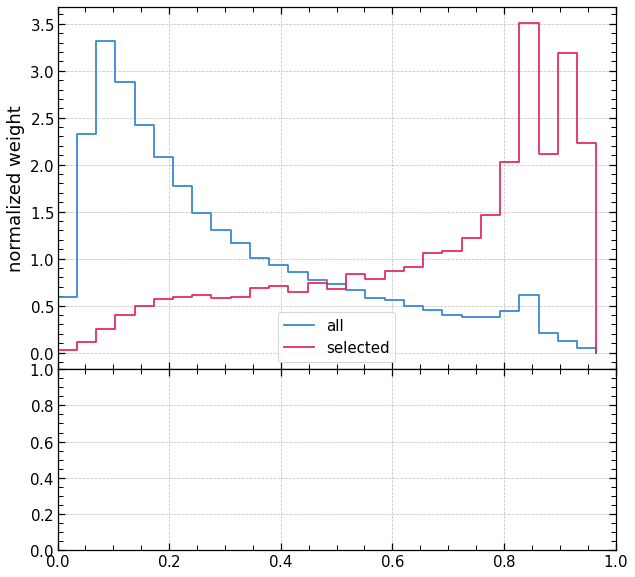

Incorporating bias "DESI:nnmag_grzw1w2" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grzw1w2"


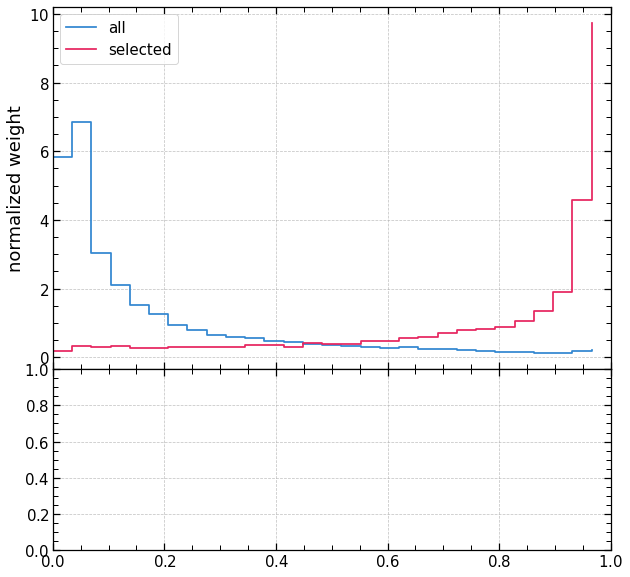

Incorporating bias "DESI:nnmag_grzw1w2w3w4" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grzw1w2w3w4"


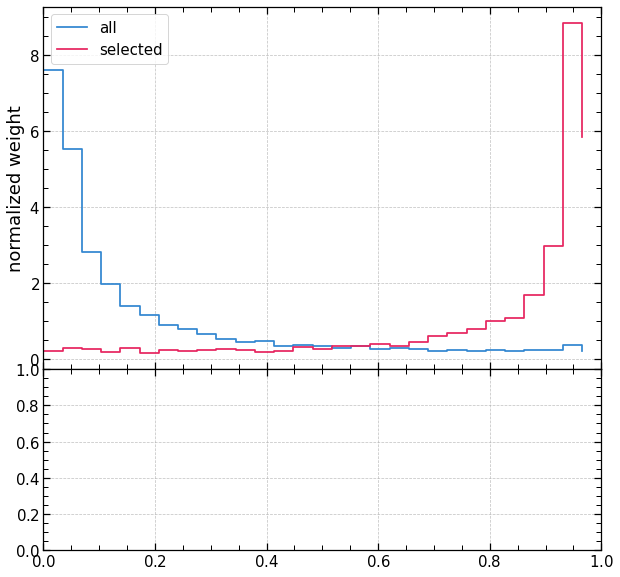


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


In [4]:

nway_res_ero = nway.nwaylib.nway_match(
[ero_table, desi_table],
**nway_args
)


    adding angular separation columns
matching: 112369 matches after filtering by search radius
Primary catalogue "EROSITA" (8175), density gives 1.83e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 8175/8175 [00:02<00:00, 3422.81it/s]
Incorporating bias "DESI:nnmag_grz" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grz"


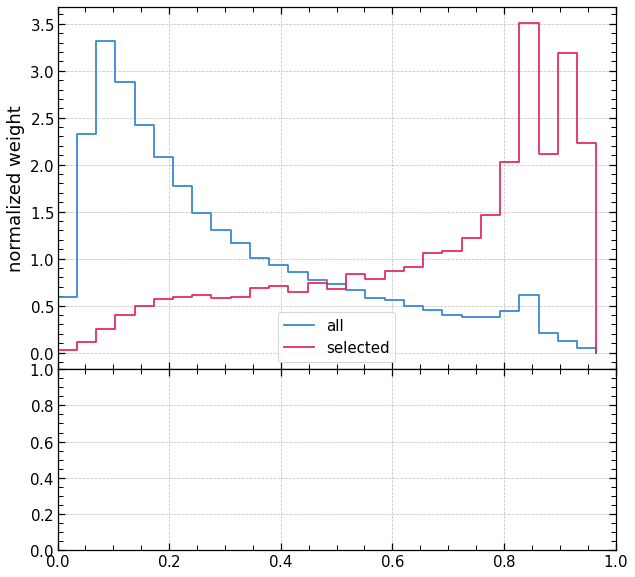

Incorporating bias "DESI:nnmag_grzw1w2" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grzw1w2"


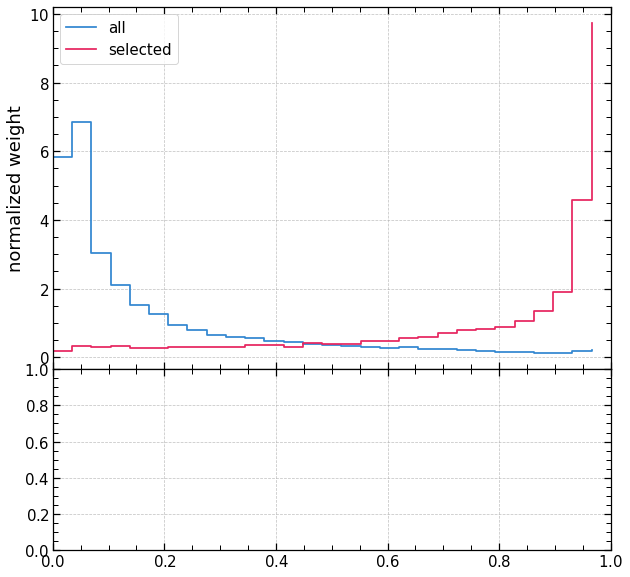

Incorporating bias "DESI:nnmag_grzw1w2w3w4" ...
magnitude histogramming: using user-supplied histogram for "DESI_nnmag_grzw1w2w3w4"


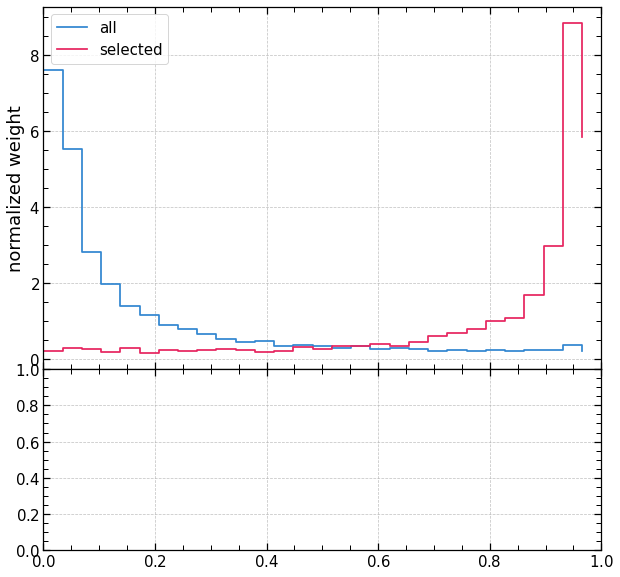


Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...


In [5]:

nway_res_ero_random = nway.nwaylib.nway_match(
[ero_random_table, desi_table],
**nway_args
)


For a false detection rate of <5%
--> use only counterparts with p_any>0.71 (66.87% of matches)
The efficiency is 82.51%
The purity is  82.62%


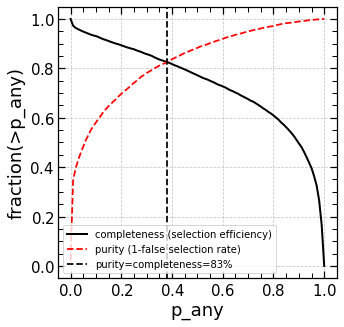

In [6]:
cutoffs, _, nway_purity = nway.calibrate_cutoff(nway_res_ero, nway_res_ero_random)

## Asses the performance of the NWAY with validation catalog (CSC & XMM)

In [7]:
nway_res_ero  = nway_res_ero.merge(ero_pandas, on='EROSITA')
nway_res_ero  = nway_res_ero.merge(desi_pandas, on='DESI')
nway_res_ero.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])
nway_res_ero.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway.pkl')

In [8]:
nway_res_ero


,EROSITA,DESI,Separation_EROSITA_DESI,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,bias_DESI_nnmag_grz,bias_DESI_nnmag_grzw1w2,bias_DESI_nnmag_grzw1w2w3w4,p_single,match_flag,prob_has_match,prob_this_match,ID,RA,DEC,pos_err,ML_FLUX_0,desi_id_true_ctp,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,col_gr,col_rz,col_gz,col_zw1,col_rw2,col_w1w2,col_zw3,col_rw4,col_w3w4,prior_type,nnmag_grzw1w2w3w4,nnmag_grzw1w2w3w4_orig,nnmag_grzw1w2,nnmag_grzw1w2_orig,nnmag_grz,nnmag_grz_orig,mag_g_orig,mag_r_orig,mag_z_orig,mag_w1_orig,mag_w2_orig,mag_w3_orig,mag_w4_orig,col_gr_orig,col_rz_orig,col_gz_orig,col_zw1_orig,col_rw2_orig,col_w1w2_orig,col_zw3_orig,col_rw4_orig,col_w3w4_orig
0,0,10477,0.042512,0.042512,2,11.113504,11.113504,9.819219e-01,1.000000,1.000000,28.924894,9.993639e-01,1,0.999364,1.000000e+00,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN,b'9011_609162_1184',159.434616,57.198786,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,b'grzw1w2w3w4',0.972917,0.972917,-99.000000,0.978616,-99.000000,0.926722,16.058165,16.111576,15.616705,14.459218,14.227020,14.269917,13.372561,-0.053411,0.494871,0.441460,1.157487,1.884556,0.232198,1.346788,2.739015,0.897356
28,0,2289777,9.399113,9.399113,2,-18.205065,-18.205065,2.608283e-28,0.332159,1.000000,1.000000,8.663644e-29,0,0.999364,5.514489e-32,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN,b'9011_609162_1223',159.439360,57.199177,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,b'grz',-99.000000,-99.000000,-99.000000,-99.000000,0.210298,0.210298,25.948793,24.556490,22.966312,NaN,NaN,NaN,NaN,1.392303,1.590178,2.982481,NaN,NaN,NaN,NaN,NaN,NaN
12,0,784834,9.507520,9.507520,2,-18.885286,-18.885286,5.446703e-29,1.000000,1.000000,0.512740,2.792744e-29,0,0.999364,1.777607e-32,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN,b'9011_609162_1210',159.437965,57.200696,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,b'grzw1w2w3w4',0.335119,0.335119,-99.000000,0.572273,-99.000000,0.303332,23.338484,23.416210,23.045345,21.072514,21.045940,17.639517,15.477362,-0.077726,0.370865,0.293139,1.972831,2.370270,0.026574,5.405828,7.938848,2.162155
19,0,1418910,10.924277,10.924277,2,-28.492115,-28.492115,1.346804e-38,1.000000,1.000000,1.000000,1.346804e-38,0,0.999364,8.572532e-42,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN,b'9011_609162_1191',159.435390,57.201792,0.685364,0.687664,-99.0,0.637958,0.613978,-99.000000,-99.000000,-0.008048,-99.0,-99.0,-99.000000,0.257898,0.083929,-99.000000,-99.000000,-99.0,b'None',-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,23.987741,24.068224,NaN,22.328527,21.489239,NaN,NaN,-0.080483,NaN,NaN,NaN,2.578985,0.839288,NaN,NaN,NaN
17,0,1123492,13.104032,13.104032,2,-45.874472,-45.874472,5.584023e-56,1.000000,0.049721,1.000000,2.776419e-57,0,0.999364,1.767216e-60,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN,b'9011_609162_1232',159.440651,57.200364,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,0.531425,-99.000000,-99.000000,-99.0,-99.0,-99.000000,-99.000000,-99.000000,0.229017,-99.000000,-99.0,b'grzw1w2',-99.000000,-99.000000,0.049987,0.049987,-99.000000,0.341792,23.716750,22.213188,20.890049,20.275759,20.926012,18.599876,NaN,1.503562,1.323139,2.826701,0.614290,1.287176,-0.650253,2.290173,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142703,9499,1335421,14.935793,14.93

NWAY PERFOMANCE ON THE VALIDATION CATALOG
Completeness and purity for nway matching 
completeness = fraction of sources with prob_has_match > p 
purity = fraction of sources with prob_has_match > p and correct nway assignment
 Completeness = 96% 
 Purity = 96% 
 prob_has_match optimal cutoff =  0.39 
 Fraction of sources with prob_has_match > 0.39 = 83%
+++Statistics+++
677 X-ray sources in validation set with counterparts
--Out of those, 28 sources were assigned hostless (prob_has_match < 0.39) 
649 sources have prob_has_match > 0.39
Out of those 649: 
--622 sources have correct nway counterpart
--27 sources have incorrect nway counterpart


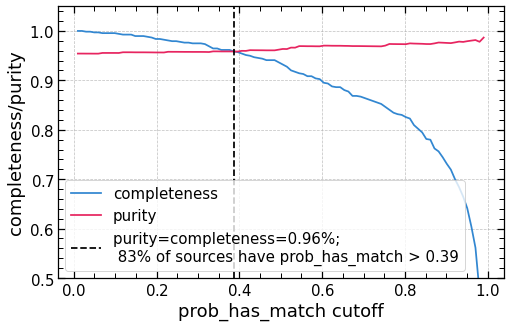

In [9]:
assess_goodnes_nway_cross_match(nway_res_ero);